In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [53]:
colab_path = 'ScadaData.txt'
local_path = 'C:\\Users\\hanna\\Desktop\\data\\ScadaData.txt'

scada_data = pd.read_csv(local_path, delimiter='\t',  parse_dates=True)
scada_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])

turbine_names = scada_data['intObjectId'].unique()[0:4]
print(turbine_names)
print("Number of turbines: " + str(len(turbine_names)))

[1748 1749 1750 1751]
Number of turbines: 4


       WindSpeedMean    intObjectId
count  235816.000000  237195.000000
mean        5.231695    1761.148148
std         2.194863       8.040211
min         0.200000    1748.000000
25%         3.600000    1754.000000
50%         5.000000    1761.000000
75%         6.700000    1768.000000
max        19.400000    1776.000000


Text(0.5, 1.0, 'Raw Data')

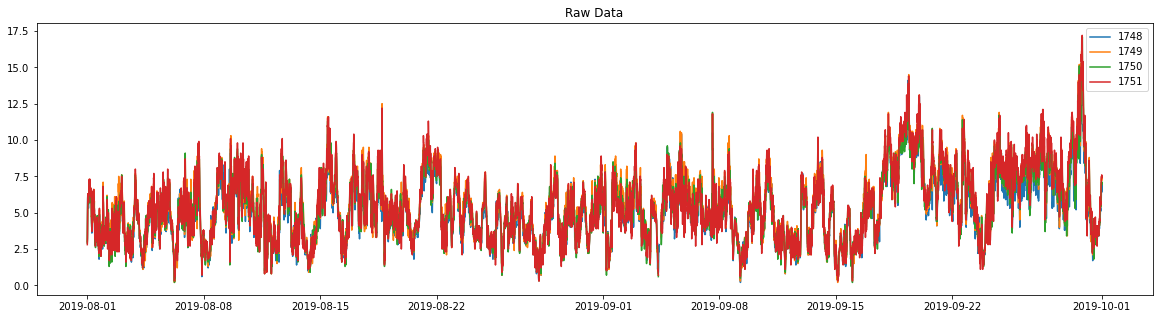

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline


wind_speed_data = scada_data[['dtTimeStamp','WindSpeedMean', 'intObjectId']]
wind_speed_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])
wind_speed_data.index=wind_speed_data['dtTimeStamp']
print(wind_speed_data.describe())

plt.figure(figsize=(20,5))
for turbine in turbine_names:
    plt.plot(wind_speed_data[wind_speed_data['intObjectId'] == turbine]["WindSpeedMean"], label=turbine)
plt.legend(loc='best')
plt.title('Raw Data')

In [106]:
from statsmodels.tsa.arima_model import ARIMA
import datetime as dt

def forecast_wind_speed(data, n_steps, train_test_split, samples_count):
    n_step = n_steps
    X = data[0:samples_count]
    size = int(len(X) * train_test_split)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train.values]
    predictions = list()
    test_indices = [i for i in range(0, len(test.values)) if i%n_step==0]
    for i in test_indices:
        model = ARIMA(history, order=(1,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast(n_step)
        yhat = output[0].flatten()
        predictions.extend(yhat)
        history.extend(test.values[i:i+n_step])
    
    return predictions


samples_to_use = 2000
train_test_split = 0.04
n_steps = 6
filtered = wind_speed_data[wind_speed_data['intObjectId'].isin(turbine_names)]
averaged = filtered[['WindSpeedMean', 'intObjectId']].groupby('dtTimeStamp').mean()[['WindSpeedMean']]
predictions_df = pd.DataFrame(index=averaged[int(samples_to_use * train_test_split):samples_to_use].index)
average_mean_wind_speeds_real = averaged[0:samples_to_use]

for turbine in turbine_names:
    print('starting turbine: ' + str(turbine))
    data = wind_speed_data[wind_speed_data['intObjectId'] == turbine]["WindSpeedMean"]  
    predictions = forecast_wind_speed(data, n_steps, train_test_split, samples_to_use)
    predictions_df[turbine] = predictions
    print('finished turbine: ' + str(turbine))
    
print(predictions_df)


starting turbine: 1748


C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


finished turbine: 1748
starting turbine: 1749


C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


finished turbine: 1749
starting turbine: 1750
finished turbine: 1750
starting turbine: 1751
finished turbine: 1751
                         1748      1749      1750      1751
dtTimeStamp                                                
2019-08-01 13:20:00  3.432943  3.763196  3.040520  3.428546
2019-08-01 13:30:00  3.442581  3.779119  3.039814  3.435781
2019-08-01 13:40:00  3.448968  3.786788  3.041403  3.443505
2019-08-01 13:50:00  3.454901  3.795749  3.042864  3.451218
2019-08-01 14:00:00  3.460772  3.804507  3.044332  3.458931
...                       ...       ...       ...       ...
2019-08-14 20:30:00  5.191000  5.595092  5.490870  5.891611
2019-08-14 20:40:00  5.192050  5.596318  5.491890  5.892894
2019-08-14 20:50:00  5.193146  5.597604  5.493200  5.894446
2019-08-14 21:00:00  5.194238  5.598886  5.494469  5.895961
2019-08-14 21:10:00  5.195331  5.600167  5.495745  5.897482

[1920 rows x 4 columns]


In [107]:
predictions_df.head(5)

,1748,1749,1750,1751
dtTimeStamp,,,,
2019-08-01 13:20:00,3.432943,3.763196,3.040520,3.428546
2019-08-01 13:30:00,3.442581,3.779119,3.039814,3.435781
2019-08-01 13:40:00,3.448968,3.786788,3.041403,3.443505
2019-08-01 13:50:00,3.454901,3.795749,3.042864,3.451218
2019-08-01 14:00:00,3.460772,3.804507,3.044332,3.458931


In [108]:
average_mean_wind_speeds_predictions = predictions_df.mean(axis=1)
print(average_mean_wind_speeds_predictions)

dtTimeStamp
2019-08-01 13:20:00    3.416301
2019-08-01 13:30:00    3.424324
2019-08-01 13:40:00    3.430166
2019-08-01 13:50:00    3.436183
2019-08-01 14:00:00    3.442135
                         ...   
2019-08-14 20:30:00    5.542143
2019-08-14 20:40:00    5.543288
2019-08-14 20:50:00    5.544599
2019-08-14 21:00:00    5.545889
2019-08-14 21:10:00    5.547181
Length: 1920, dtype: float64


In [109]:
print(average_mean_wind_speeds_real)

                     WindSpeedMean
dtTimeStamp                       
2019-08-01 00:00:00          2.925
2019-08-01 00:10:00          3.325
2019-08-01 00:20:00          4.675
2019-08-01 00:30:00          6.100
2019-08-01 00:40:00          6.250
...                            ...
2019-08-14 20:30:00          5.525
2019-08-14 20:40:00          5.175
2019-08-14 20:50:00          5.225
2019-08-14 21:00:00          5.800
2019-08-14 21:10:00          6.025

[2000 rows x 1 columns]


In [110]:
combined_df = pd.concat([average_mean_wind_speeds_predictions, average_mean_wind_speeds_real], axis=1)
print(combined_df)

                            0  WindSpeedMean
dtTimeStamp                                 
2019-08-01 00:00:00       NaN          2.925
2019-08-01 00:10:00       NaN          3.325
2019-08-01 00:20:00       NaN          4.675
2019-08-01 00:30:00       NaN          6.100
2019-08-01 00:40:00       NaN          6.250
...                       ...            ...
2019-08-14 20:30:00  5.542143          5.525
2019-08-14 20:40:00  5.543288          5.175
2019-08-14 20:50:00  5.544599          5.225
2019-08-14 21:00:00  5.545889          5.800
2019-08-14 21:10:00  5.547181          6.025

[2000 rows x 2 columns]


Text(0.5, 1.0, 'Real vs Predictions')

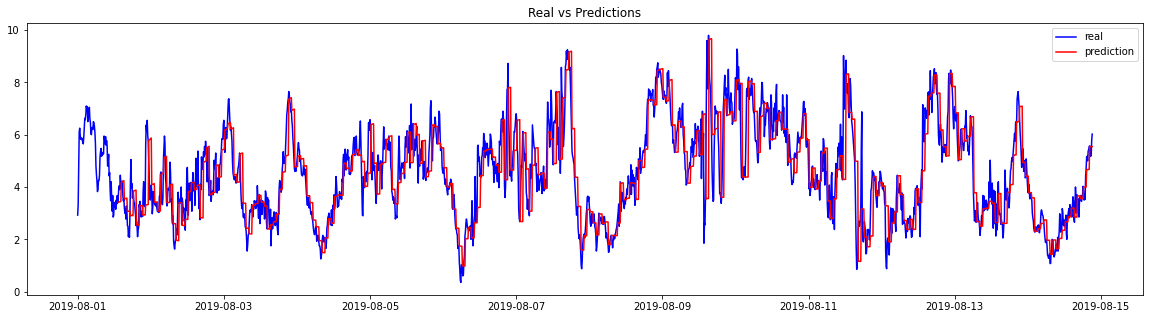

In [111]:
plt.figure(figsize=(20,5))
plt.plot(combined_df['WindSpeedMean'], color='blue', label='real')
plt.plot(combined_df[0], color='red', label='prediction')
plt.legend(loc='best')
plt.title('Real vs Predictions')

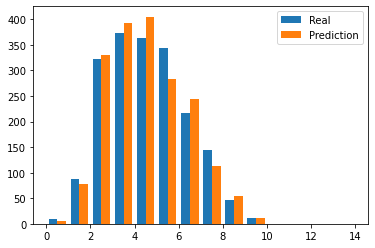

In [112]:
combined_df = combined_df.dropna()

plt.hist([combined_df['WindSpeedMean'], combined_df[0]], bins=list(range(0,15)), label=['Real', 'Prediction'])
plt.legend(loc='upper right')
plt.show()

In [113]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(combined_df['WindSpeedMean'], combined_df[0])
print('Test MSE: %.3f' % error)

Test MSE: 1.016
